In [64]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
import scipy.optimize as opt
from scipy.special import factorial
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col
%matplotlib inline

In [4]:
data_ps4 = pd.read_stata('PS4_data.dta')
data_ps4.head()

,id68,year,intid,relhh,hannhrs,wannhrs,hlabinc,wlabinc,nochild,wrace,...,redpregovinc,hsex,wsex,age,wage,hpersno,wpersno,hyrsed,wyrsed,pce
0,1,1967,1,Head,1200.0,2000.0,NaN,NaN,0,NaN,...,5614.0,1.0,2.0,52.0,46.0,1.0,2.0,8.0,8.0,0.0
1,2,1967,2,Head,0.0,0.0,NaN,NaN,0,NaN,...,0.0,1.0,2.0,56.0,57.0,1.0,2.0,3.0,3.0,0.0
2,3,1967,3,Head,0.0,0.0,NaN,NaN,0,NaN,...,0.0,1.0,2.0,77.0,64.0,1.0,2.0,NaN,3.0,0.0
3,4,1967,4,Head,1560.0,0.0,NaN,NaN,6,1.0,...,3280.0,1.0,2.0,45.0,44.0,1.0,2.0,8.0,5.0,0.0
4,5,1967,5,Head,2500.0,2000.0,NaN,NaN,3,1.0,...,7900.0,1.0,2.0,24.0,22.0,1.0,2.0,10.0,9.0,0.0


In [11]:
# For this problem set, we will keep males (hsex == 1) who are older than 25 and younger than 60 (age >= 25 & age <= 60),
# and also make MORE than 7 dollars hourly (hlabinc / hannhrs > 7)

data_ps4['hrwage'] = (data_ps4['hlabinc'] / data_ps4['hannhrs'])

In [15]:
ps4_mod = data_ps4[(data_ps4['hsex'] == 1) & # male
                   (data_ps4['age'] >= 25) & (data_ps4['age'] <= 60) & # age 25-60
                   (data_ps4['hrwage'] > 7) & (data_ps4['hannhrs'] != 0)] # hourly wage above 7

In [16]:
ps4_mod.describe()

,id68,year,intid,hannhrs,wannhrs,hlabinc,wlabinc,nochild,wrace,hrace,...,hsex,wsex,age,wage,hpersno,wpersno,hyrsed,wyrsed,pce,hrwage
count,57477.000000,57477.000000,57477.000000,57477.000000,57477.000000,5.747700e+04,37442.000000,57477.000000,51988.000000,57381.000000,...,57477.0,50180.0,57477.000000,50180.000000,57477.000000,50180.000000,57097.000000,49825.000000,57477.000000,57477.000000
mean,1507.533935,1986.635245,3484.484507,2228.364990,994.471619,5.280176e+04,23166.681641,1.173026,1.086905,1.102630,...,1.0,2.0,39.224247,37.308151,59.409206,67.729515,13.529993,13.212443,0.617346,24.306034
std,828.790640,8.744894,2254.476920,619.743286,927.341492,5.228071e+04,21082.244141,1.216322,0.345212,0.371816,...,0.0,0.0,9.579065,9.563719,78.759903,81.602432,2.449510,2.167871,0.206892,25.154028
min,1.000000,1971.000000,1.000000,2.000000,0.000000,1.666980e+01,1.192780,0.000000,1.000000,1.000000,...,1.0,2.0,25.000000,16.000000,1.000000,1.000000,1.000000,1.000000,0.247121,7.000252
25%,782.000000,1979.000000,1694.000000,1952.000000,0.000000,3.035003e+04,8926.479492,0.000000,1.000000,1.000000,...,1.0,2.0,31.000000,29.000000,1.000000,2.000000,12.000000,12.000000,0.421747,13.947624
50%,1542.000000,1987.000000,3301.000000,2160.000000,960.000000,4.377034e+04,19527.019531,1.000000,1.000000,1.000000,...,1.0,2.0,38.000000,36.000000,4.000000,4.000000,13.000000,12.000000,0.635834,19.905161
75%,2225.000000,1994.000000,5006.000000,2517.000000,1904.000000,6.136955e+04,31881.078125,2.000000,1.000000,1.000000,...,1.0,2.0,47.000000,44.000000,170.000000,170.000000,16.000000,15.000000,0.803488,27.787226
max,2930.000000,2002.000000,16968.000000,5840.000000,5840.000000,3.771521e+06,417271.468750,11.000000,8.000000,3.000000,...,1.0,2.0,60.000000,70.000000,227.000000,230.000000,17.000000,17.000000,0.928007,1717.330322


From what we see above, our data are prepped for the 3 requirements outlined at the beginning of the problem set.

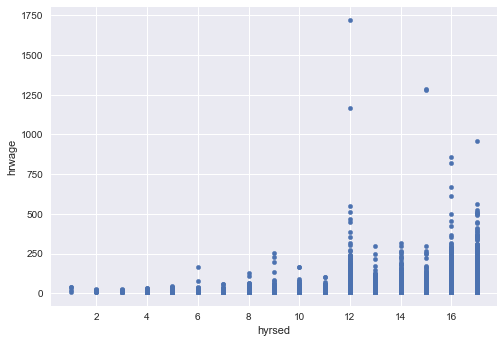

In [65]:
plt.style.use('seaborn')

ps4_mod.plot(x='hyrsed', y='hrwage', kind='scatter')
plt.show()

The plot shows a positive relationship visually, but to what extent, it isn't necessarily clear. Before we delve into the main model of the problem set, let's examine a linear regression of hourly wage on education alone.

$$
ln(w_{i,t}) = \alpha + \beta_{1}Educ_{i,t} + \epsilon_{i,t}
$$

In [38]:
pd.options.mode.chained_assignment = None  # default='warn'

# Creating natural log variable for our estimation
ps4_mod['ln_wage'] = np.log(ps4_mod['hrwage'])

Now that we've handled our wage variable by applying the natural log to it, what does our scatter plot look like now?

Well, it's beginning to be more clear as to the positive impact education seems to be having on wage.

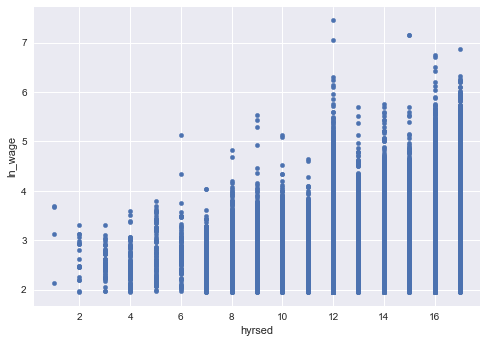

In [42]:
ps4_mod.plot(x='hyrsed', y='ln_wage', kind='scatter')
plt.show()

In [47]:
'''
For our initial model of examining education on wage alone, we still
go through the practice of creating a "constant" variable, so to speak,
which will be a column of the value 1, then we estimate the OLS regression.
'''

ps4_mod['constant'] = 1

# now the model
ps4_reg1 = sm.OLS(endog=ps4_mod['ln_wage'], exog=ps4_mod[['constant', 'hyrsed']], \
    missing='drop')

In [50]:
results = ps4_reg1.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                ln_wage   R-squared:                       0.119
Model:                            OLS   Adj. R-squared:                  0.119
Method:                 Least Squares   F-statistic:                     7727.
Date:                Mon, 04 Oct 2021   Prob (F-statistic):               0.00
Time:                        23:27:28   Log-Likelihood:                -42645.
No. Observations:               57097   AIC:                         8.529e+04
Df Residuals:                   57095   BIC:                         8.531e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
constant       1.9732      0.012    164.486      0.0

In [62]:
# What is the percentage effect of education on wage in this model?
effect1 = round(100 * (math.exp(0.0767)-1), 2)
print('Effect of education on wage: ' + str(effect1) + "%")

Effect of education on wage: 7.97%


From a model where we examine the effect of education alone, the effect of each year of education is positive to the magnitude of *7.97 percent*

# Primary Model for the Problem Set

We will examine the following model at $t$ = 1971, 1980, 1990, and 2000 respectively, via the Maximum Likelihood Estimator:

$$
ln(w_{i,t}) = \alpha + \beta_{1}Educ_{i,t} + \beta_{2}Age_{i,t} + \beta_{3}Age^{2}_{i,t} + \beta_{4}Black_{i,t} + \beta_{5}Hispanic_{i,t} + \beta_{6}OtherRace_{i,t} + \epsilon_{i,t}
$$

We will use this linear model to check OLS against the MLE.

In [119]:
'''
The function following this documentation will allow us to create a "race" variable,
which we will then dummy code for each race, and generate age squared, which we will also need
'''

def ethnicity(x):
    if x == 1:
        return 'White'
    elif x == 2:
        return 'Black'
    else:
        return 'Other race'
    
ps4_mod['race'] = ps4_mod['hrace'].apply(lambda x: ethnicity(x))
ps4_mod['age_2'] = ps4_mod['age'] * ps4_mod['age']

In [120]:
race_dummies = pd.get_dummies(ps4_mod['race'])

In [124]:
model_vartemp = pd.DataFrame(ps4_mod, columns=['year','ln_wage','hyrsed','age','age_2','hrace', 'constant'])
modelvars = pd.concat([model_vartemp, race_dummies], axis=1)

In [127]:
modelvars.describe()

,year,ln_wage,hyrsed,age,age_2,hrace,constant,Black,Other race,White
count,57477.000000,57477.000000,57097.000000,57477.000000,57477.000000,57381.000000,57477.0,57477.000000,57477.000000,57477.000000
mean,1986.635245,3.010414,13.529993,39.224247,1629.789673,1.102630,1.0,0.056388,0.024706,0.918907
std,8.744894,0.543891,2.449510,9.579065,791.694885,0.371816,0.0,0.230671,0.155228,0.272981
min,1971.000000,1.945946,1.000000,25.000000,625.000000,1.000000,1.0,0.000000,0.000000,0.000000
25%,1979.000000,2.635309,12.000000,31.000000,961.000000,1.000000,1.0,0.000000,0.000000,1.000000
50%,1987.000000,2.990979,13.000000,38.000000,1444.000000,1.000000,1.0,0.000000,0.000000,1.000000
75%,1994.000000,3.324576,16.000000,47.000000,2209.000000,1.000000,1.0,0.000000,0.000000,1.000000
max,2002.000000,7.448526,17.000000,60.000000,3600.000000,3.000000,1.0,1.000000,1.000000,1.000000


In [186]:
# MLL

data = {}
y = {}
result = {}
time = [1971, 1980, 1990, 2000]
initial_guess = np.array([0, 0.5, 0.04, -0.06, -0.03, 0])

for i in time:
    data[i] = modelvars[modelvars.year == i]
    y[i] = data[i]['ln_wage']
    
    #Objective function
    def obj_fn(param):
        '''
        param = betas
        e = SS error
        nll = Negative likelihood f'n
        
        '''
        beta0 = param[0]
        beta1 = param[1]
        beta2 = param[2]
        beta3 = param[3]
        beta4 = param[4]
        beta5 = param[5]
        
        # Predicted Y
        yhat = beta0 + beta1 * data[i]['hyrsed'] + beta2 * data[i]['age'] + beta3 * data[i]['age_2'] + beta4 * data[i]['Black'] + beta5 * data[i]['Other race']
        
        e = np.array((y[i] - yhat) ** 2).sum()
        return e
        
        nll = -np.sum(stats.norm.logpdf(y[i], loc = yhat[i]))
        return(nll)
    
    # Our minimized function
    result[i] = opt.minimize(obj_fn, initial_guess, method= 'SLSQP')
    print('Year:', i , '\nEstimate:', result[i].x[1])

Year: 1971 
Estimate: nan
Year: 1980 
Estimate: nan
Year: 1990 
Estimate: nan
Year: 2000 
Estimate: nan


In [188]:
# Ordinary Least Square estimation results for each year
data = {}
x = {}
result = {}
time = [1971, 1980, 1990, 2000]

for i in time:
    data[i] = modelvars[modelvars.year == i]
    x[i] = data[i][['hyrsed', 'age', 'age_2', 'Black', 'Other race']]
    result[i] = sm.OLS(data[i]["ln_wage"], x[i], missing = 'drop').fit()
    print('Year:', i, '\n{}'.format(result[i].params[0]))

Year: 1971 
0.06957632303237915
Year: 1980 
0.07106568664312363
Year: 1990 
0.0968417152762413
Year: 2000 
0.10810508579015732


In [189]:
# 1971
effect_1971 = round(100 * (math.exp(0.069576)-1), 2)
print('Effect of education on wage in 1971: ' + str(effect_1971) + "%")

# 1980
effect_1980 = round(100 * (math.exp(0.071066)-1), 2)
print('Effect of education on wage in 1971: ' + str(effect_1980) + "%")

# 1990
effect_1990 = round(100 * (math.exp(0.0968417)-1), 2)
print('Effect of education on wage in 1971: ' + str(effect_1990) + "%")

# 2000
effect_main = round(100 * (math.exp(0.108105)-1), 2)
print('Effect of education on wage in 1971: ' + str(effect_main) + "%")

Effect of education on wage in 1971: 7.21%
Effect of education on wage in 1971: 7.37%
Effect of education on wage in 1971: 10.17%
Effect of education on wage in 1971: 11.42%


The MLE approach, and the OLS regression, show an increase in wage as years of education increases. However, the effect was not showing a change in my Negative Likelihood output, for some reason, and it was rounded.  When we compare results, we see that the OLS regression sees an increasing effect of education on wages over time. Using $100\times{}exp(\beta_{est}-1)$, we can see the actual percentage main effect of increasing education by one year on the hourly wage.

- 1971: 7.21 %
- 1980: 7.37 %
- 1990: 10.17 %
- 2000: 11.42 %